<a href="https://colab.research.google.com/github/bhadranp/bhadranp/blob/main/20231302_Walmart_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!virtualenv /content/drive/MyDrive/LJMU/colab_env

/bin/bash: line 1: virtualenv: command not found


In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/LJMU/LJMU/Research/Datasets/Walmart Dataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!source /content/drive/MyDrive/LJMU/colab_env/activate; pip install git+https://github.com/sktime/sktime.git

/bin/bash: line 1: /content/drive/MyDrive/LJMU/colab_env/activate: No such file or directory
  Cloning https://github.com/sktime/sktime.git to /tmp/pip-req-build-2dqugygj
  Running command git clone --filter=blob:none --quiet https://github.com/sktime/sktime.git /tmp/pip-req-build-2dqugygj
  Resolved https://github.com/sktime/sktime.git to commit e6db37821ddff239d239e523443415ff31a6a0aa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 4.3 MB/s eta 0:00:00
  Created wheel for sktime: filename=sktime-0.27.0-py3-none-any.whl size=21878114 sha256=4c7d5f8ceddcd89de859ff638e6aa513a1f76ed18afbd74753bf1476e4fa090a
  Stored in directory: /tmp/pip-ephem-wheel-cache-dikryr8m/wheels/ee/2f/cc/af4d7b4a1effce06f53e66751c126823b75a33e7579bd9ef8e
Successfully built sktime


In [ ]:
!source /content/drive/MyDrive/LJMU/colab_env/activate; pip install git+https://github.com/blue-yonder/tsfresh

/bin/bash: line 1: /content/drive/MyDrive/LJMU/colab_env/activate: No such file or directory
  Cloning https://github.com/blue-yonder/tsfresh to /tmp/pip-req-build-j6cv4_cz
  Running command git clone --filter=blob:none --quiet https://github.com/blue-yonder/tsfresh /tmp/pip-req-build-j6cv4_cz
  Resolved https://github.com/blue-yonder/tsfresh to commit af039f93a521fdc94bdc059cf4dd73a751905932
  Preparing metadata (setup.py) ... done


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/LJMU/colab_env/lib/python3.8/site-packages")

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import tsfresh
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction.settings import MinimalFCParameters

In [ ]:
# Import Data
train_data = pd.read_csv('/content/train.csv')
features_data = pd.read_csv('/content/features.csv')
stores_data = pd.read_csv('/content/stores.csv')
test_data = pd.read_csv('/content/test.csv')

In [ ]:
data = pd.merge(train_data,stores_data,on='Store',how='inner')
data = pd.merge(data,features_data,on=['Store','Date'],how='left')

data['Date'] = pd.to_datetime(data['Date'],errors='coerce')
data.sort_values(by=['Date'],inplace=True)
data.set_index(data.Date, inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,False


In [ ]:
round((data.isnull().sum() * 100 / len(data)),1)

Store            0.0
Dept             0.0
Date             0.0
Weekly_Sales     0.0
IsHoliday_x      0.0
Type             0.0
Size             0.0
Temperature      0.0
Fuel_Price       0.0
MarkDown1       64.3
MarkDown2       73.6
MarkDown3       67.5
MarkDown4       68.0
MarkDown5       64.1
CPI              0.0
Unemployment     0.0
IsHoliday_y      0.0
dtype: float64

In [ ]:
data.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [ ]:
for i in range(1,6):
  data["MarkDown"+str(i)] = data["MarkDown"+str(i)].apply(lambda x: 0 if x<0 else x )
  data["MarkDown"+str(i)].fillna(value=0,inplace=True)

In [ ]:
round((data.isnull().sum() * 100 / len(data)),1)

Store           0.0
Dept            0.0
Date            0.0
Weekly_Sales    0.0
IsHoliday_x     0.0
Type            0.0
Size            0.0
Temperature     0.0
Fuel_Price      0.0
MarkDown1       0.0
MarkDown2       0.0
MarkDown3       0.0
MarkDown4       0.0
MarkDown5       0.0
CPI             0.0
Unemployment    0.0
IsHoliday_y     0.0
dtype: float64

In [ ]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,False,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,False,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,False,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,False,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False


In [ ]:
#check whether the column IsHoliday_x and IsHoliday_y are same or not
data['IsHoliday_x'].isin(data['IsHoliday_y']).all()

True

In [ ]:
#Since this two columns are same so drop any one column and make another column as IsHoliday
data.drop(columns='IsHoliday_x',inplace=True)
data.rename(columns={"IsHoliday_y" : "IsHoliday"}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   Type          421570 non-null  object        
 5   Size          421570 non-null  int64         
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  I

In [ ]:
# Convert Weekly_Sales to numeric
data["Weekly_Sales"] = pd.to_numeric(data["Weekly_Sales"])

In [ ]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.week
data.head()

<ipython-input-22-f66000ff13a9>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['Week'] = data['Date'].dt.week


,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2010,2,5
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5


In [ ]:
data.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,880.070274,468.092929,1083.132268,1662.772385,171.201947,7.960289,2010.968591,6.449510,25.826762
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.520381,5528.872994,3894.529945,4207.629321,39.159276,1.863296,0.796876,3.243217,14.151887
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,0.000000,0.000000,0.000000,0.000000,126.064000,3.879000,2010.000000,1.000000,1.000000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,2010.000000,4.000000,14.000000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,2011.000000,6.000000,26.000000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,2012.000000,9.000000,38.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2012.000000,12.000000,52.000000


In [ ]:
data['Total_MarkDown'] = data['MarkDown1']+data['MarkDown2']+data['MarkDown3']+data['MarkDown4']+data['MarkDown5']
data.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1,inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,Total_MarkDown
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,False,2010,2,5,0.0
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,131.527903,10.064,False,2010,2,5,0.0
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,131.527903,10.064,False,2010,2,5,0.0
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,131.527903,10.064,False,2010,2,5,0.0
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,131.527903,10.064,False,2010,2,5,0.0


In [ ]:
data['IsHoliday'] = data['IsHoliday'].astype('int')
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,Total_MarkDown
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,0.0
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,131.527903,10.064,0,2010,2,5,0.0
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,131.527903,10.064,0,2010,2,5,0.0
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,131.527903,10.064,0,2010,2,5,0.0
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,131.527903,10.064,0,2010,2,5,0.0


## **Data Visualization**

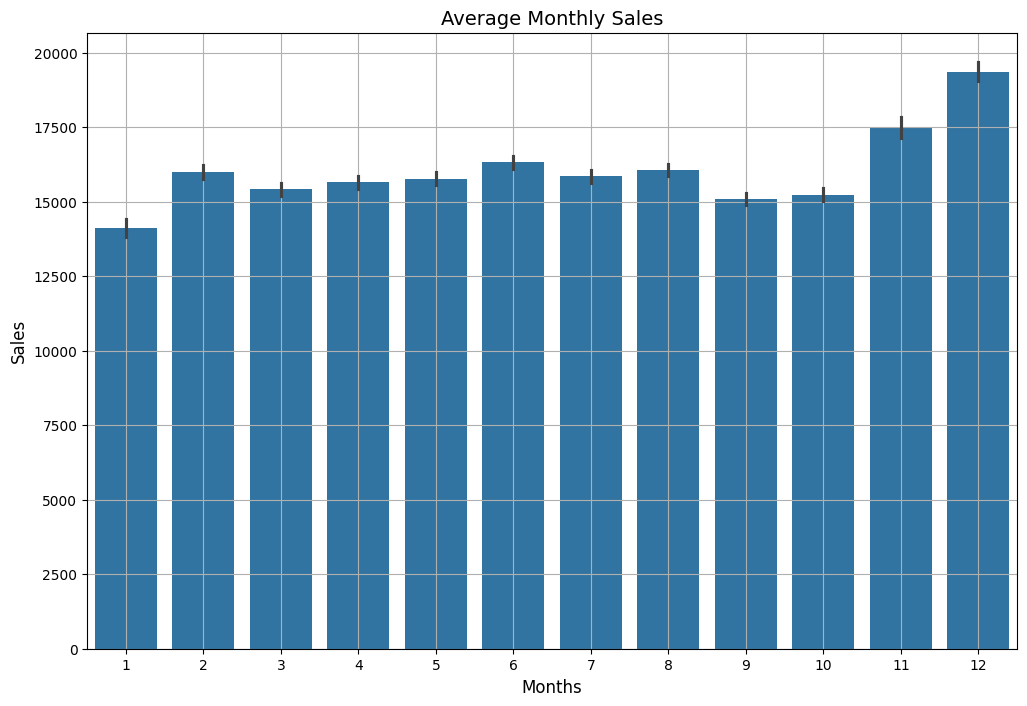

In [ ]:
#Average Monthly Sales
plt.figure(figsize=(12,8))
sns.barplot(x='Month',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=12)
plt.xlabel('Months',fontsize=12)
plt.title('Average Monthly Sales',fontsize=14)
plt.savefig('avg_monthly_sales.png')
plt.grid()

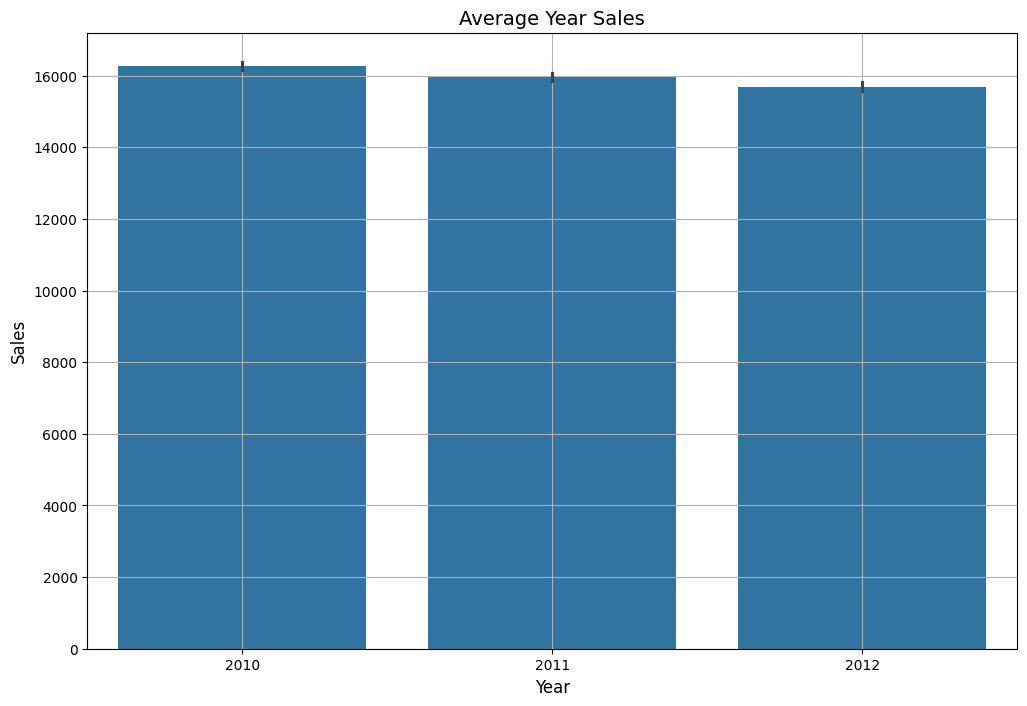

In [ ]:
#Average Year Sales
plt.figure(figsize=(12,8))
sns.barplot(x='Year',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=12)
plt.xlabel('Year',fontsize=12)
plt.title('Average Year Sales',fontsize=14)
plt.savefig('avg_year_sales.png')
plt.grid()

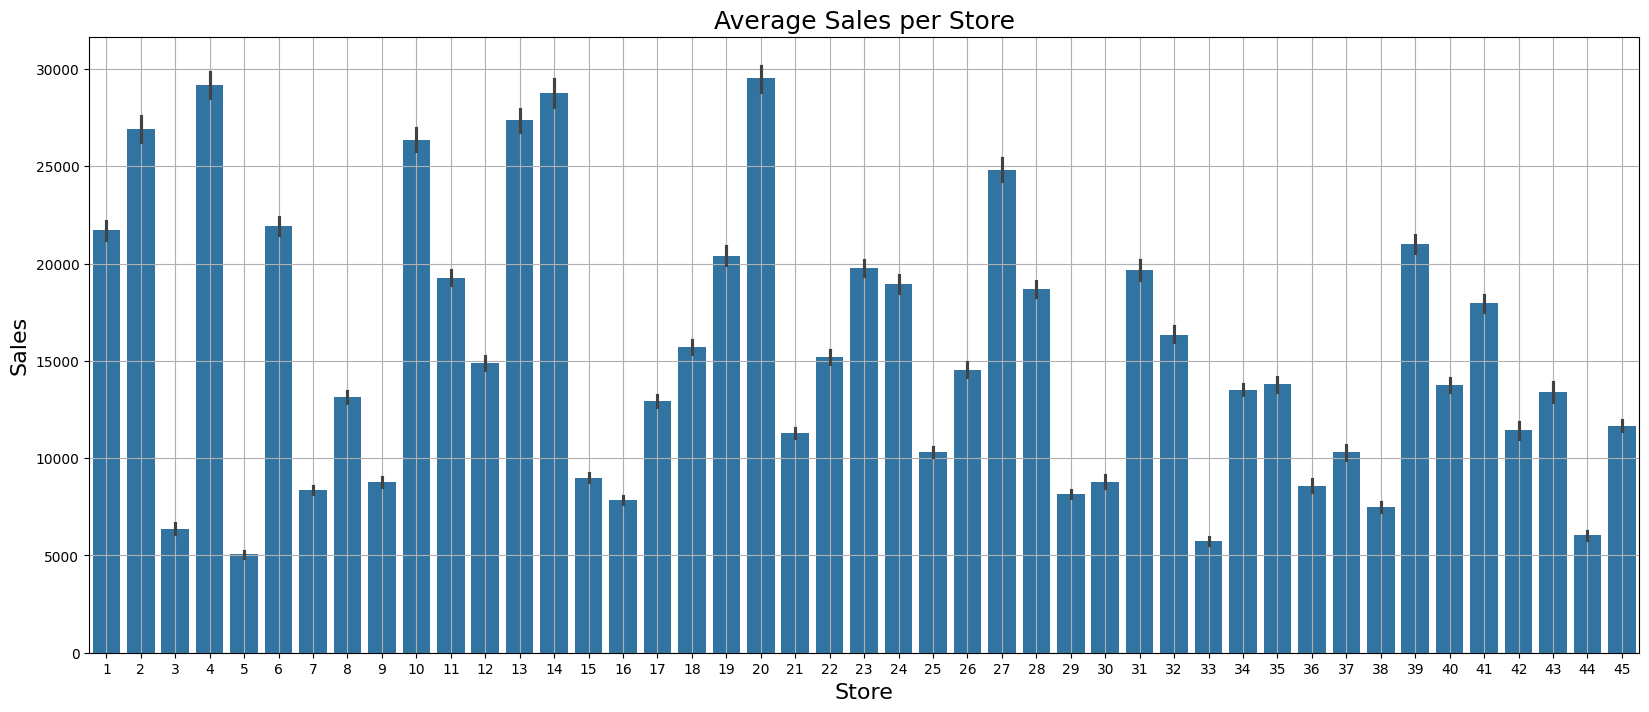

In [ ]:
#Average Weekly Sales Store wise
plt.figure(figsize=(20,8))
sns.barplot(x='Store',y='Weekly_Sales',data=data)
plt.grid()
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.savefig('avg_sales_store.png')
plt.show()

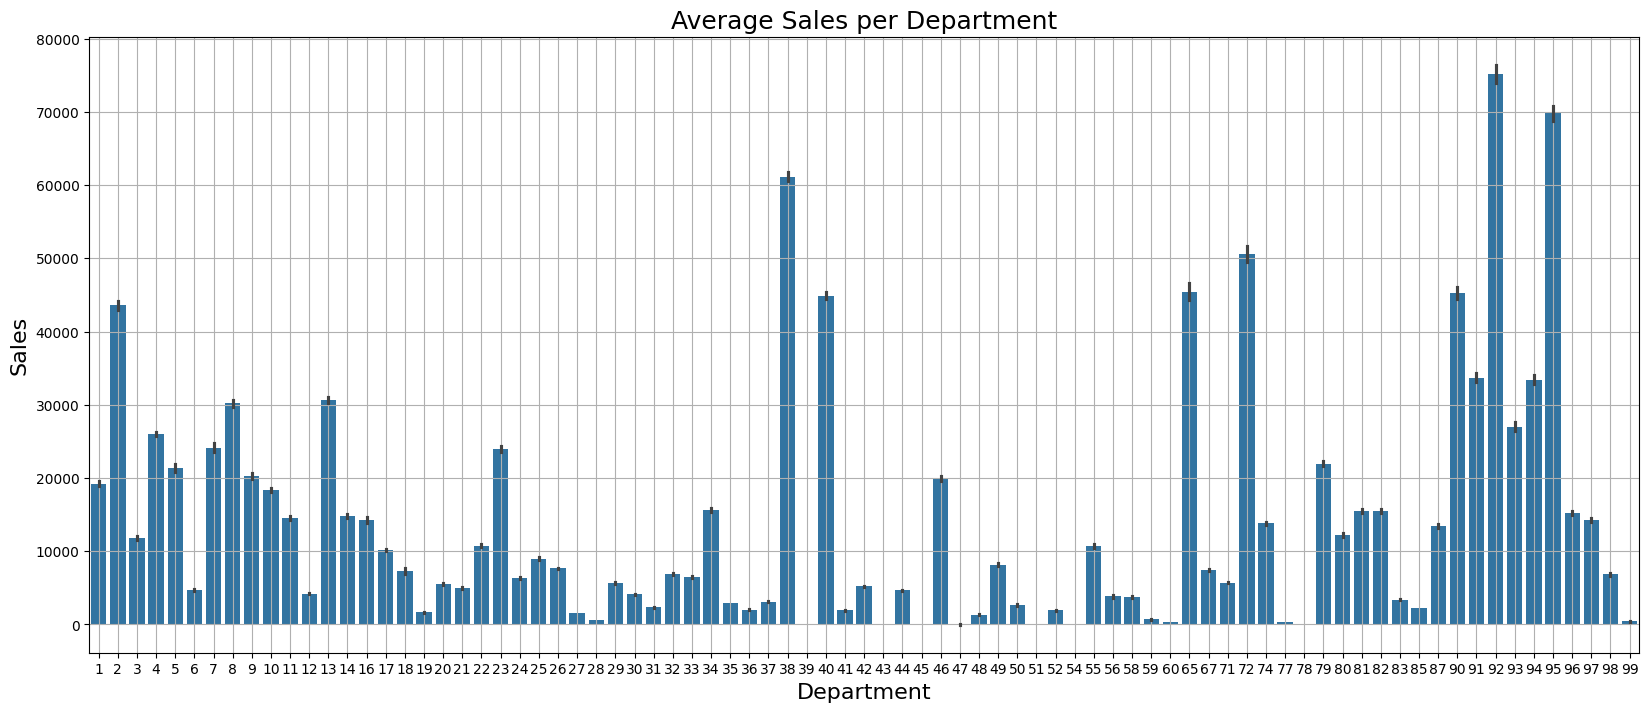

In [ ]:
# Average sales per department
plt.figure(figsize=(20,8))
sns.barplot(x='Dept',y='Weekly_Sales',data=data)
plt.grid()
plt.title('Average Sales per Department', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.savefig('avg_sales_dept.png')
plt.show()

<Figure size 1000x800 with 0 Axes>

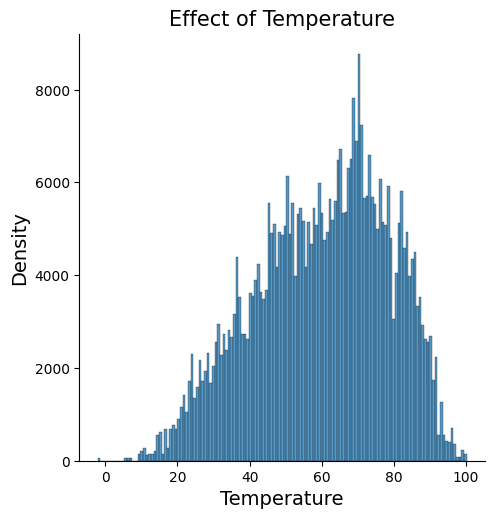

In [ ]:
# Effect of Temperature on Sales
plt.figure(figsize=(10,8))
sns.displot(data['Temperature'])
plt.title('Effect of Temperature',fontsize=15)
plt.xlabel('Temperature',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.savefig('effect_of_temp.png')
plt.show()

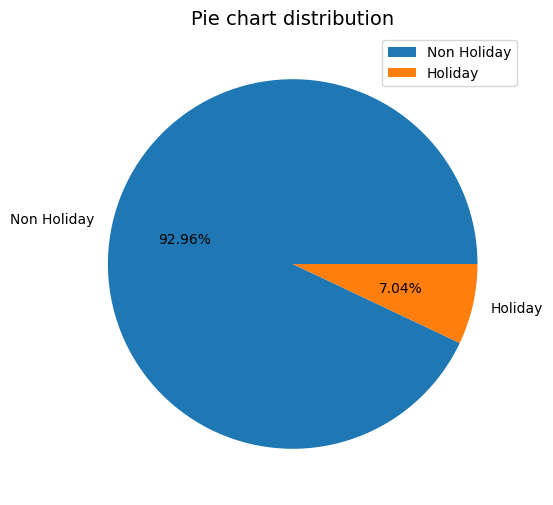

In [ ]:
# Holiday Distribution
plt.figure(figsize=(6,6))
plt.pie(data['IsHoliday'].value_counts(),labels=['Non Holiday','Holiday'],autopct='%0.2f%%')
plt.title("Pie chart distribution",fontsize=14)
plt.legend()
plt.savefig('holiday_distribution.png')
plt.show()

In [ ]:
df = pd.merge(train_data,stores_data,on='Store',how='inner')
df = pd.merge(df,features_data,on=['Store','Date'],how='left')

In [ ]:
df.drop(columns='IsHoliday_x',inplace=True)
df.rename(columns={"IsHoliday_y" : "IsHoliday"}, inplace=True)

In [ ]:
for i in range(1,6):
  df["MarkDown"+str(i)] = df["MarkDown"+str(i)].apply(lambda x: 0 if x<0 else x )
  df["MarkDown"+str(i)].fillna(value=0,inplace=True)

In [ ]:
df['Total_MarkDown'] = df['MarkDown1']+df['MarkDown2']+df['MarkDown3']+df['MarkDown4']+df['MarkDown5']
df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1,inplace=True)

In [ ]:
file_name = 'df_store.xlsx'
df.to_excel(file_name)

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,False,0.0
1,1,1,2010-02-12,46039.49,A,151315,38.51,2.548,211.242170,8.106,True,0.0
2,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,211.289143,8.106,False,0.0
3,1,1,2010-02-26,19403.54,A,151315,46.63,2.561,211.319643,8.106,False,0.0
4,1,1,2010-03-05,21827.90,A,151315,46.50,2.625,211.350143,8.106,False,0.0


In [ ]:
# prompt: I need the sum of all department sales based on stores and date. I need to recreate the same 'df'  dataframe columns with same number of columns.

df_grouped = df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
df_grouped.columns = ['Store', 'Date', 'Total_Sales']
df_new = df.merge(df_grouped, on=['Store', 'Date'], how='left')
df_new['Total_Sales']=df_new.Total_Sales.astype('int')
df_new=df_new.drop(['Weekly_Sales','Dept'],axis=1)
df_new.head()

,Store,Date,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Total_Sales
0,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690
1,1,2010-02-12,A,151315,38.51,2.548,211.242170,8.106,True,0.0,1641957
2,1,2010-02-19,A,151315,39.93,2.514,211.289143,8.106,False,0.0,1611968
3,1,2010-02-26,A,151315,46.63,2.561,211.319643,8.106,False,0.0,1409727
4,1,2010-03-05,A,151315,46.50,2.625,211.350143,8.106,False,0.0,1554806


## Trial 1

In [ ]:
#df["Date"] = df.index

df['date'] = pd.to_datetime(df['Date'],errors='coerce')
df.sort_values(by=['date'],inplace=True)

In [ ]:
df.set_index(df.date, inplace=True)
df.drop(['date'], axis = 1,inplace=True)

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown
date,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,False,0.0
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,131.527903,10.064,False,0.0
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,131.527903,10.064,False,0.0
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,131.527903,10.064,False,0.0
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,131.527903,10.064,False,0.0


In [ ]:
df_rolled = roll_time_series(df, column_id="Store", column_sort="Date",
                             max_timeshift=20, min_timeshift=5)

Rolling: 100%|██████████| 10474/10474 [19:13<00:00,  9.08it/s]


In [ ]:
df_rolled.head(30)

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,id
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
1,1,11,2010-02-05,24213.18,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
2,1,20,2010-02-05,5034.10,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
3,1,4,2010-02-05,39954.04,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
4,1,8,2010-02-05,40129.01,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
5,1,10,2010-02-05,30721.50,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
270,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
271,1,11,2010-02-05,24213.18,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
272,1,20,2010-02-05,5034.10,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"
273,1,4,2010-02-05,39954.04,A,151315,42.31,2.572,211.096358,8.106,False,0.0,"(1, 2010-02-05)"


In [ ]:
df_rolled.tail(30)

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,id
8585082,45,42,2012-10-26,4894.78,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585083,45,41,2012-10-26,1954.67,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585084,45,44,2012-10-26,3144.09,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585085,45,90,2012-10-26,25352.32,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585086,45,82,2012-10-26,17360.33,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585087,45,92,2012-10-26,54608.75,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585088,45,38,2012-10-26,47799.07,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585089,45,40,2012-10-26,38673.87,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585090,45,95,2012-10-26,56017.47,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"
8585700,45,72,2012-10-26,33366.60,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,"(45, 2012-10-26)"


In [ ]:
df_extract = extract_features(df_rolled,
                     column_id="id", column_sort="Date", column_value="Weekly_Sales", default_fc_parameters=MinimalFCParameters(),
                     impute_function=impute, show_warnings=False)

In [ ]:
df_extract.head(50)

Weekly_Sales__sum_values  Weekly_Sales__median  \
1 2010-02-05               28663750.31              11609.50   
  2010-02-12               34457481.26              11873.89   
  2010-02-19               31908332.79              12290.16   
  2010-02-26               33785695.95              11135.17   
  2010-03-05               32884212.02              12571.50   
  2010-03-12               28457960.95               9907.51   
  2010-03-19               29956845.66              11709.00   
  2010-03-26               32239388.79              11097.80   
  2010-04-02               32271597.97              11157.08   
  2010-04-09               33646110.75              10109.00   
  2010-04-16               29755183.92               9855.89   
  2010-04-23               30833387.55              11082.83   
  2010-04-30               26675332.51               9368.81   
  2010-05-07               31844796.53               9970.00   
  2010-05-14               35608035.83              12803.67   
  2010-05-21               28185763.22               8604.28   
  2010-05-28               31375611.96              11229.88   
  2010-06-04               32010312.41               8841.86   
  2010-06-11               31483731.28              10784.84   
  2010-06-18               32301507.34              10119.00   
  2010-06-25               30782250.31              10562.29   
  2010-07-02               31921641.48              10720.79   
  2010-07-09               32670866.14               9082.50   
  2010-07-16               29427387.65              10391.77   
  2010-07-23               29670497.20               9980.29   
  2010-07-30               30555274.56               9643.04   
  2010-08-06               31575496.20              10210.44   
  2010-08-13               31526543.25              11884.61   
  2010-08-20               30914575.09              10421.34   
  2010-08-27               33987961.56              13570.32   
  2010-09-03               29495612.22               9170.32   
  2010-09-10               29895490.09               9250.00   
  2010-09-17               31959668.71               9199.14   
  2010-09-24               27550408.75               8404.83   
  2010-10-01               32286912.27               9775.17   
  2010-10-08               32435042.58              10103.94   
  2010-10-15               29268628.89               9056.33   
  2010-10-22               29364857.26               9422.39   
  2010-10-29               26590648.52               8198.62   
  2010-11-05               34532794.31              12033.61   
  2010-11-12               30370428.28               8943.59   
  2010-11-19               28463140.81               8943.59   
  2010-11-26               42366124.78              16373.34   
  2010-12-03               34518186.37              10536.65   
  2010-12-10               36271252.49              11219.78   
  2010-12-17               39445976.59              13487.50   
  2010-12-24               49994585.32              17933.00   
  2010-12-31               27179213.19               8386.33   
  2011-01-07               31491746.71               9024.94   
  2011-01-14               26704000.00               6816.68   

              Weekly_Sales__mean  Weekly_Sales__length  \
1 2010-02-05        21914.182194                1308.0   
  2010-02-12        22789.339458                1512.0   
  2010-02-19        20814.307104                1533.0   
  2010-02-26        22345.037004                1512.0   
  2010-03-05        21450.888467                1533.0   
  2010-03-12        18563.575310                1533.0   
  2010-03-19        19812.728611                1512.0   
  2010-03-26        21322.347083                1512.0   
  2010-04-02        21343.649451                1512.0   
  2010-04-09        21947.886986                1533.0   
  2010-04-16        19409.774247                1533.0   
  2010-04-23        20392.452083                1512.

In [ ]:
df_extract.head(50)

Weekly_Sales__sum_values  Weekly_Sales__median  \
1 2010-02-05               28663750.31              11609.50   
  2010-02-12               34457481.26              11873.89   
  2010-02-19               31908332.79              12290.16   
  2010-02-26               33785695.95              11135.17   
  2010-03-05               32884212.02              12571.50   
  2010-03-12               28457960.95               9907.51   
  2010-03-19               29956845.66              11709.00   
  2010-03-26               32239388.79              11097.80   
  2010-04-02               32271597.97              11157.08   
  2010-04-09               33646110.75              10109.00   
  2010-04-16               29755183.92               9855.89   
  2010-04-23               30833387.55              11082.83   
  2010-04-30               26675332.51               9368.81   
  2010-05-07               31844796.53               9970.00   
  2010-05-14               35608035.83              12803.67   
  2010-05-21               28185763.22               8604.28   
  2010-05-28               31375611.96              11229.88   
  2010-06-04               32010312.41               8841.86   
  2010-06-11               31483731.28              10784.84   
  2010-06-18               32301507.34              10119.00   
  2010-06-25               30782250.31              10562.29   
  2010-07-02               31921641.48              10720.79   
  2010-07-09               32670866.14               9082.50   
  2010-07-16               29427387.65              10391.77   
  2010-07-23               29670497.20               9980.29   
  2010-07-30               30555274.56               9643.04   
  2010-08-06               31575496.20              10210.44   
  2010-08-13               31526543.25              11884.61   
  2010-08-20               30914575.09              10421.34   
  2010-08-27               33987961.56              13570.32   
  2010-09-03               29495612.22               9170.32   
  2010-09-10               29895490.09               9250.00   
  2010-09-17               31959668.71               9199.14   
  2010-09-24               27550408.75               8404.83   
  2010-10-01               32286912.27               9775.17   
  2010-10-08               32435042.58              10103.94   
  2010-10-15               29268628.89               9056.33   
  2010-10-22               29364857.26               9422.39   
  2010-10-29               26590648.52               8198.62   
  2010-11-05               34532794.31              12033.61   
  2010-11-12               30370428.28               8943.59   
  2010-11-19               28463140.81               8943.59   
  2010-11-26               42366124.78              16373.34   
  2010-12-03               34518186.37              10536.65   
  2010-12-10               36271252.49              11219.78   
  2010-12-17               39445976.59              13487.50   
  2010-12-24               49994585.32              17933.00   
  2010-12-31               27179213.19               8386.33   
  2011-01-07               31491746.71               9024.94   
  2011-01-14               26704000.00               6816.68   

              Weekly_Sales__mean  Weekly_Sales__length  \
1 2010-02-05        21914.182194                1308.0   
  2010-02-12        22789.339458                1512.0   
  2010-02-19        20814.307104                1533.0   
  2010-02-26        22345.037004                1512.0   
  2010-03-05        21450.888467                1533.0   
  2010-03-12        18563.575310                1533.0   
  2010-03-19        19812.728611                1512.0   
  2010-03-26        21322.347083                1512.0   
  2010-04-02        21343.649451                1512.0   
  2010-04-09        21947.886986                1533.0   
  2010-04-16        19409.774247                1533.0   
  2010-04-23        20392.452083                1512.

In [ ]:
df_extract.shape

(6435, 10)

In [ ]:
df.shape

## Trial 2

In [ ]:
#df["Date"] = df.index

df_new['date'] = pd.to_datetime(df['Date'],errors='coerce')
df_new.sort_values(by=['date'],inplace=True)

In [ ]:
df_new.set_index(df_new.date, inplace=True)
df_new.drop(['date'], axis = 1,inplace=True)

In [ ]:
df_new.head()

,Store,Date,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Total_Sales
date,,,,,,,,,,,
2010-02-05,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690
2010-02-05,29,2010-02-05,B,93638,24.36,2.788,131.527903,10.064,False,0.0,538634
2010-02-05,29,2010-02-05,B,93638,24.36,2.788,131.527903,10.064,False,0.0,538634
2010-02-05,29,2010-02-05,B,93638,24.36,2.788,131.527903,10.064,False,0.0,538634
2010-02-05,29,2010-02-05,B,93638,24.36,2.788,131.527903,10.064,False,0.0,538634


In [ ]:
df_rolled2 = roll_time_series(df_new, column_id="Store", column_sort="Date",
                             max_timeshift=20, min_timeshift=5)

Rolling: 100%|██████████| 10474/10474 [25:08<00:00,  6.94it/s]


In [ ]:
df_rolled2.head(10)

,Store,Date,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Total_Sales,id
0,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
1,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
2,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
3,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
4,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
5,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
270,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
271,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
272,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"
273,1,2010-02-05,A,151315,42.31,2.572,211.096358,8.106,False,0.0,1643690,"(1, 2010-02-05)"


In [ ]:
df_rolled2.tail(10)

,Store,Date,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Total_Sales,id
8585711,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585712,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585713,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585714,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585715,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585716,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585717,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585718,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585719,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"
8585720,45,2012-10-26,B,118221,58.85,3.882,192.308899,8.667,False,5247.26,760281,"(45, 2012-10-26)"


In [ ]:
df_extract2 = extract_features(df_rolled2,
                     column_id="id", column_sort="Date", column_value="Total_Sales", default_fc_parameters=MinimalFCParameters(),
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 6435/6435 [00:25<00:00, 252.26it/s]


In [ ]:
df_extract2.head(20)

Total_Sales__sum_values  Total_Sales__median  Total_Sales__mean  \
1 2010-02-05             2.149947e+09            1643690.0       1.643690e+06   
  2010-02-12             2.483003e+09            1641957.0       1.642198e+06   
  2010-02-19             2.477445e+09            1611968.0       1.616076e+06   
  2010-02-26             2.173978e+09            1409727.0       1.437816e+06   
  2010-03-05             2.353051e+09            1554806.0       1.534932e+06   
  2010-03-12             2.231022e+09            1439541.0       1.455331e+06   
  2010-03-19             2.219518e+09            1472515.0       1.467935e+06   
  2010-03-26             2.137795e+09            1404429.0       1.413885e+06   
  2010-04-02             2.371578e+09            1594968.0       1.568504e+06   
  2010-04-09             2.379531e+09            1545418.0       1.552206e+06   
  2010-04-16             2.264133e+09            1466058.0       1.476929e+06   
  2010-04-23             2.119287e+09            1391256.0       1.401645e+06   
  2010-04-30             2.117717e+09            1425100.0       1.420333e+06   
  2010-05-07             2.387620e+09            1603955.0       1.579114e+06   
  2010-05-14             2.282345e+09            1494251.0       1.509488e+06   
  2010-05-21             2.077367e+09            1399662.0       1.413175e+06   
  2010-05-28             2.098336e+09            1432069.0       1.427439e+06   
  2010-06-04             2.370221e+09            1615524.0       1.589685e+06   
  2010-06-11             2.315281e+09            1542561.0       1.552837e+06   
  2010-06-18             2.186507e+09            1503284.0       1.508976e+06   

              Total_Sales__length  Total_Sales__standard_deviation  \
1 2010-02-05               1308.0                         0.000000   
  2010-02-12               1512.0                       599.324333   
  2010-02-19               1533.0                     10311.204467   
  2010-02-26               1512.0                     69941.115128   
  2010-03-05               1533.0                     49882.931503   
  2010-03-12               1533.0                     39631.897791   
  2010-03-19               1512.0                     11403.416371   
  2010-03-26               1512.0                     23546.218445   
  2010-04-02               1512.0                     65894.206097   
  2010-04-09               1533.0                     17036.919581   
  2010-04-16               1533.0                     27286.577961   
  2010-04-23               1512.0                     25868.816381   
  2010-04-30               1491.0                     11773.030121   
  2010-05-07               1512.0                     61853.522017   
  2010-05-14               1512.0                     37938.994042   
  2010-05-21               1470.0                     33099.255040   
  2010-05-28               1470.0                     11340.087728   
  2010-06-04               1491.0                     63816.961379   
  2010-06-11               1491.0                     25381.030515   
  2010-06-18               1449.0                     13826.594422   

              Total_Sales__variance  Total_Sales__root_mean_square  \
1 2010-02-05           0.000000e+00                   1.643690e+06   
  2010-02-12           3.591897e+05                   1.642198e+06   
  2010-02-19           1.063209e+08                   1.616109e+06   
  2010-02-26           4.891760e+09                   1.439516e+06   
  2010-03-05           2.488307e+09                   1.535743e+06   
  2010-03-12           1.570687e+09                   1.455870e+06   
  2010-03-19           1.300379e+08                   1.467980e+06   
  2010-03-26           5.544244e+08                   1.414081e+06   
  2010-04-02           4.342046e+09                   1.569888e+06   
  2010-04-09           2.902566e+08                   1.552299e+06   
  2010-04-16           7.445573e+08                   1.477181e+06   
 

In [ ]:
df_extract2.head(20)

Total_Sales__sum_values  Total_Sales__median  Total_Sales__mean  \
1 2010-02-05             2.149947e+09            1643690.0       1.643690e+06   
  2010-02-12             2.483003e+09            1641957.0       1.642198e+06   
  2010-02-19             2.477445e+09            1611968.0       1.616076e+06   
  2010-02-26             2.173978e+09            1409727.0       1.437816e+06   
  2010-03-05             2.353051e+09            1554806.0       1.534932e+06   
  2010-03-12             2.231022e+09            1439541.0       1.455331e+06   
  2010-03-19             2.219518e+09            1472515.0       1.467935e+06   
  2010-03-26             2.137795e+09            1404429.0       1.413885e+06   
  2010-04-02             2.371578e+09            1594968.0       1.568504e+06   
  2010-04-09             2.379531e+09            1545418.0       1.552206e+06   
  2010-04-16             2.264133e+09            1466058.0       1.476929e+06   
  2010-04-23             2.119287e+09            1391256.0       1.401645e+06   
  2010-04-30             2.117717e+09            1425100.0       1.420333e+06   
  2010-05-07             2.387620e+09            1603955.0       1.579114e+06   
  2010-05-14             2.282345e+09            1494251.0       1.509488e+06   
  2010-05-21             2.077367e+09            1399662.0       1.413175e+06   
  2010-05-28             2.098336e+09            1432069.0       1.427439e+06   
  2010-06-04             2.370221e+09            1615524.0       1.589685e+06   
  2010-06-11             2.315281e+09            1542561.0       1.552837e+06   
  2010-06-18             2.186507e+09            1503284.0       1.508976e+06   

              Total_Sales__length  Total_Sales__standard_deviation  \
1 2010-02-05               1308.0                         0.000000   
  2010-02-12               1512.0                       599.324333   
  2010-02-19               1533.0                     10311.204467   
  2010-02-26               1512.0                     69941.115128   
  2010-03-05               1533.0                     49882.931503   
  2010-03-12               1533.0                     39631.897791   
  2010-03-19               1512.0                     11403.416371   
  2010-03-26               1512.0                     23546.218445   
  2010-04-02               1512.0                     65894.206097   
  2010-04-09               1533.0                     17036.919581   
  2010-04-16               1533.0                     27286.577961   
  2010-04-23               1512.0                     25868.816381   
  2010-04-30               1491.0                     11773.030121   
  2010-05-07               1512.0                     61853.522017   
  2010-05-14               1512.0                     37938.994042   
  2010-05-21               1470.0                     33099.255040   
  2010-05-28               1470.0                     11340.087728   
  2010-06-04               1491.0                     63816.961379   
  2010-06-11               1491.0                     25381.030515   
  2010-06-18               1449.0                     13826.594422   

              Total_Sales__variance  Total_Sales__root_mean_square  \
1 2010-02-05           0.000000e+00                   1.643690e+06   
  2010-02-12           3.591897e+05                   1.642198e+06   
  2010-02-19           1.063209e+08                   1.616109e+06   
  2010-02-26           4.891760e+09                   1.439516e+06   
  2010-03-05           2.488307e+09                   1.535743e+06   
  2010-03-12           1.570687e+09                   1.455870e+06   
  2010-03-19           1.300379e+08                   1.467980e+06   
  2010-03-26           5.544244e+08                   1.414081e+06   
  2010-04-02           4.342046e+09                   1.569888e+06   
  2010-04-09           2.902566e+08                   1.552299e+06   
  2010-04-16           7.445573e+08                   1.477181e+06   
 

In [ ]:
df_extract2.shape

(6435, 10)

In [ ]:
df.shape

(421570, 12)